In [ ]:
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import calendar 
from datetime import datetime

In [ ]:
import glob
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##TRAIN데이터 불러오기

In [ ]:
path = '/content/drive/MyDrive/ColabNotebooks/AiSpark/TRAIN_DATA'  # 여러분의 CSV 파일이 위치한 폴더 경로로 변경하세요.
all_files = glob.glob(path + '/*.csv')

data_frames = []

for file in all_files:
    df = pd.read_csv(file, index_col=None, header=0)
    data_frames.append(df)

train = pd.concat(data_frames, axis=0, ignore_index=True)

##TEST데이터 불러오기

In [ ]:
path = '/content/drive/MyDrive/ColabNotebooks/AiSpark/TEST_DATA'  # 여러분의 CSV 파일이 위치한 폴더 경로로 변경하세요.
all_files = glob.glob(path + '/*.csv')

data_frames = []

for file in all_files:
    df = pd.read_csv(file, index_col=None, header=0)
    data_frames.append(df)

test = pd.concat(data_frames, axis=0, ignore_index=True)

##결측 데이터 선형 보간

In [ ]:
train = train.interpolate(method='linear')
test = test.interpolate(method='linear')

In [ ]:
train.head()

,연도,일시,측정소,PM2.5,기온(°C),습도(%)
0,0,01-01 00:00,공주,0.056,0.173776,0.828
1,0,01-01 01:00,공주,0.060,0.176935,0.831
2,0,01-01 02:00,공주,0.068,0.180095,0.784
3,0,01-01 03:00,공주,0.060,0.178515,0.745
4,0,01-01 04:00,공주,0.068,0.164297,0.750


##일시 칼럼 전처리

In [ ]:
def apply_leap_year(start_year, dayofyear):
    year = start_year
    while True:
        if pd.Timestamp(year).is_leap_year:
            if dayofyear > 366:
                dayofyear -= 366
                year += 1
            else:
                break
        else:
            if dayofyear > 365:
                dayofyear -= 365
                year += 1
            else:
                break
    return year, dayofyear

# 일시(datetime) 열의 형식 변경
train['일시'] = pd.to_datetime(train['일시'], format='%m-%d %H:%M', errors='coerce')

# 시작 년도 설정
start_year = 2016

# 윤년을 고려한 년도 정보 추가
train['일시'] = train['일시'].apply(lambda x: x.replace(year=apply_leap_year(start_year, x.dayofyear)[0]) if not pd.isna(x) else x)


In [ ]:
train.head()

,연도,일시,측정소,PM2.5,기온(°C),습도(%)
0,0,2016-01-01 00:00:00,공주,0.056,0.173776,0.828
1,0,2016-01-01 01:00:00,공주,0.060,0.176935,0.831
2,0,2016-01-01 02:00:00,공주,0.068,0.180095,0.784
3,0,2016-01-01 03:00:00,공주,0.060,0.178515,0.745
4,0,2016-01-01 04:00:00,공주,0.068,0.164297,0.750


##쓸모없어진 '연도' 칼럼 삭제

In [ ]:
train.drop(columns=['연도'], inplace=True)

In [ ]:
train.head()

,일시,측정소,PM2.5,기온(°C),습도(%)
0,2016-01-01 00:00:00,공주,0.056,0.173776,0.828
1,2016-01-01 01:00:00,공주,0.060,0.176935,0.831
2,2016-01-01 02:00:00,공주,0.068,0.180095,0.784
3,2016-01-01 03:00:00,공주,0.060,0.178515,0.745
4,2016-01-01 04:00:00,공주,0.068,0.164297,0.750


In [ ]:
missing_values_count = train.isnull().sum()
print(missing_values_count)

일시        408
측정소         0
PM2.5       0
기온(°C)      0
습도(%)       0
dtype: int64


In [ ]:
train = train.dropna(subset=['일시'])

In [ ]:
missing_values_count = train.isnull().sum()
print(missing_values_count)

일시        0
측정소       0
PM2.5     0
기온(°C)    0
습도(%)     0
dtype: int64


In [ ]:
# 일시 데이터를 년, 월, 일 칼럼으로 정수 형태로 분리 (결측값 처리)
train['년'] = train['일시'].apply(lambda x: pd.to_datetime(x).year if not pd.isna(x) else x).astype(pd.Int64Dtype())

# 월과 일 칼럼을 2자리 숫자 형태로 추가 (결측값 처리)
train['월'] = train['일시'].apply(lambda x: pd.to_datetime(x).strftime('%m') if not pd.isna(x) else x)
train['일'] = train['일시'].apply(lambda x: pd.to_datetime(x).strftime('%d') if not pd.isna(x) else x)

# 시간 칼럼 추가 (결측값 처리)
train['시간'] = train['일시'].apply(lambda x: pd.to_datetime(x).strftime('%H:%M') if not pd.isna(x) else x)


In [ ]:
train.head()

,일시,측정소,PM2.5,기온(°C),습도(%),년,월,일,시간
0,2016-01-01 00:00:00,공주,0.056,0.173776,0.828,2016,01,01,00:00
1,2016-01-01 01:00:00,공주,0.060,0.176935,0.831,2016,01,01,01:00
2,2016-01-01 02:00:00,공주,0.068,0.180095,0.784,2016,01,01,02:00
3,2016-01-01 03:00:00,공주,0.060,0.178515,0.745,2016,01,01,03:00
4,2016-01-01 04:00:00,공주,0.068,0.164297,0.750,2016,01,01,04:00


In [ ]:
# 일시 칼럼 삭제
train.drop(columns=['일시'], inplace=True)

In [ ]:
# 년, 월, 일, 시간 칼럼을 0, 1, 2, 3번째 위치로 옮기기
cols = train.columns.tolist()
cols = cols[-4:] + cols[:-4]
train = train[cols]

In [ ]:
# 월 칼럼을 정수(integer)로 변환
train['월'] = train['월'].astype(int)

# 계절 정보 추가 (1:봄 2:여름 3:가을 4:겨울)
train['계절'] = train['월'].apply(lambda x: (x % 12 + 3) // 3)

In [ ]:
# 계절 칼럼을 4번째 위치로 옮기기
cols = train.columns.tolist()
cols.remove('계절')
cols.insert(4, '계절')
train = train[cols]

In [ ]:
train.head()

,년,월,일,시간,계절,측정소,PM2.5,기온(°C),습도(%)
0,2016,1,01,00:00,1,공주,0.056,0.173776,0.828
1,2016,1,01,01:00,1,공주,0.060,0.176935,0.831
2,2016,1,01,02:00,1,공주,0.068,0.180095,0.784
3,2016,1,01,03:00,1,공주,0.060,0.178515,0.745
4,2016,1,01,04:00,1,공주,0.068,0.164297,0.750


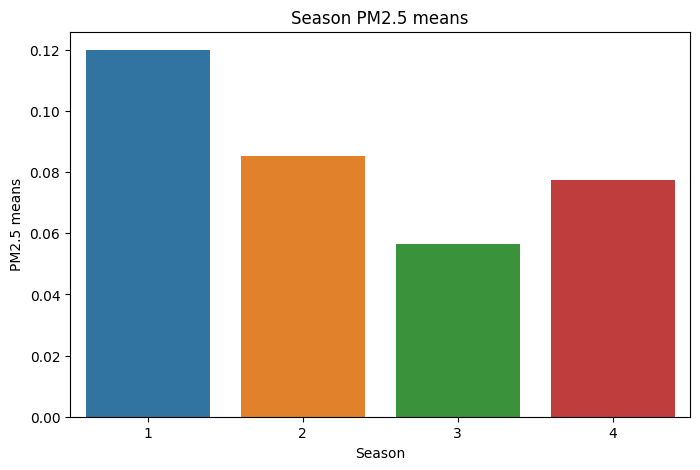

In [ ]:
# 계절별 PM2.5 평균값 계산
seasonal_means = train.groupby('계절')['PM2.5'].mean().reset_index()

# 계절 이름 설정
seasonal_names = {1: 'spring', 2: 'summer', 3: 'fall', 4: 'winter'}
seasonal_means['계절절'] = seasonal_means['계절'].map(seasonal_names)

# 시각화
plt.figure(figsize=(8, 5))
sns.barplot(x='계절', y='PM2.5', data=seasonal_means)
plt.title('Season PM2.5 means')
plt.xlabel('Season')
plt.ylabel('PM2.5 means')
plt.show()

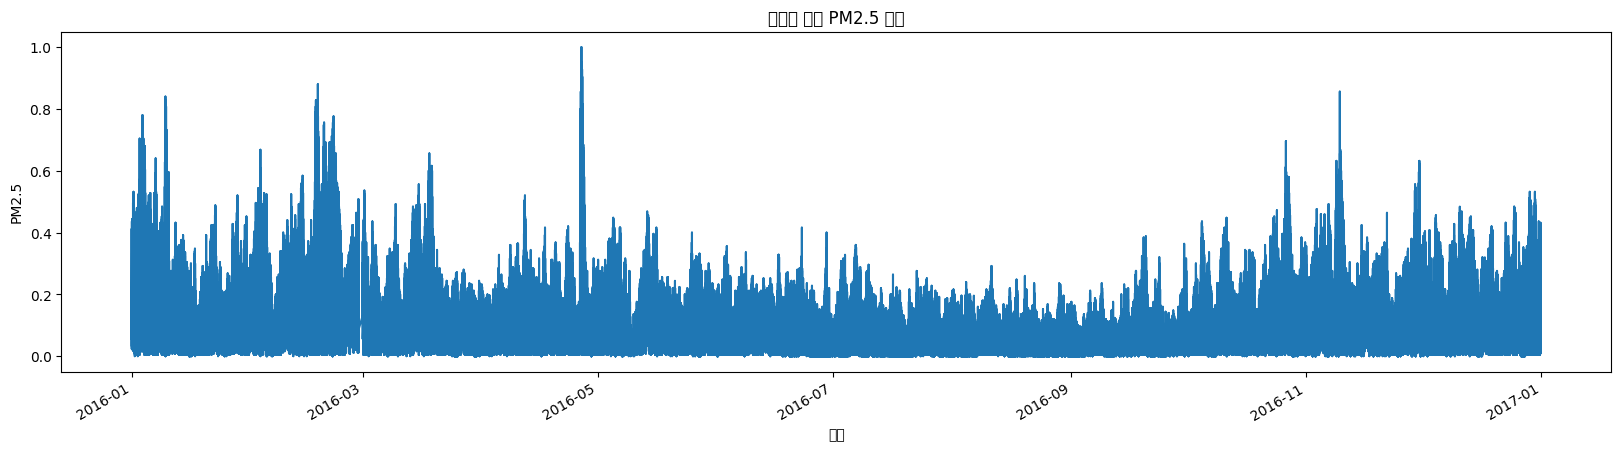

In [ ]:
# 문자열 타입을 정수 타입으로 변환
train['년'] = train['년'].astype(int)
train['월'] = train['월'].astype(int)
train['일'] = train['일'].astype(int)

# 시간 칼럼에서 시간 부분만 추출하여 정수로 변환
train['시간'] = train['시간'].apply(lambda x: int(x.split(':')[0]))

# 일시(datetime) 열 생성
train['일시'] = train['년'].astype(str) + '-' + train['월'].astype(str) + '-' + train['일'].astype(str) + ' ' + train['시간'].astype(str) + ':00'
train['일시'] = pd.to_datetime(train['일시'], format='%Y-%m-%d %H:%M')
train.set_index('일시', inplace=True)

# PM2.5 시계열 데이터 시각화
plt.figure(figsize=(20, 5))
train['PM2.5'].plot()
plt.title('시간에 따른 PM2.5 변화')
plt.ylabel('PM2.5')
plt.show()

In [ ]:
# 일시(datetime) 열 생성
train['일시'] = pd.to_datetime(train['년'].astype(str) + '-' + train['월'].astype(str) + '-' + train['일'].astype(str) + ' ' + train['시간'].astype(str) + ':00')
train.set_index('일시', inplace=True)

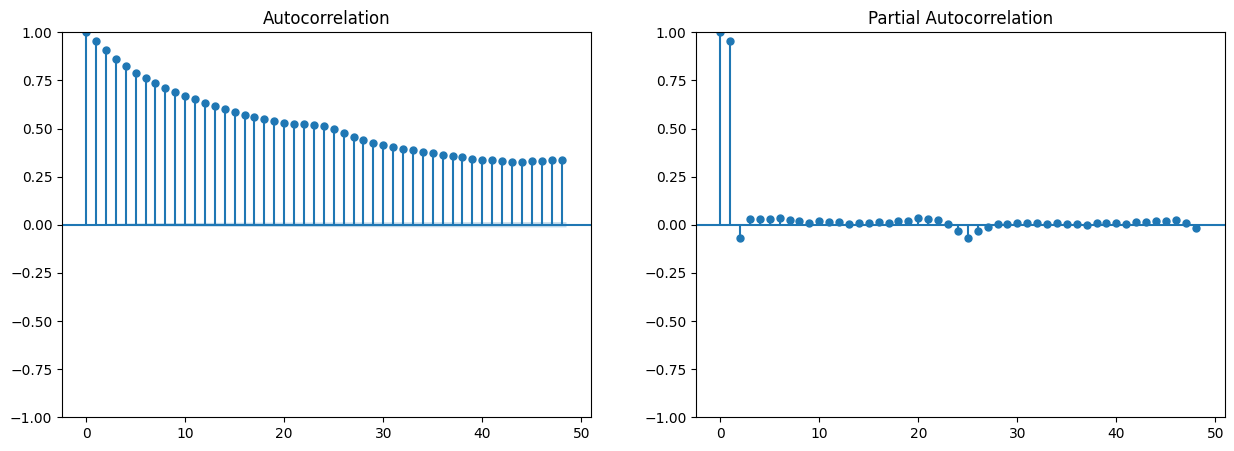

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 일시(datetime) 열 생성
#train['일시'] = pd.to_datetime(train[['년', '월', '일', '시간']])
#train.set_index('일시', inplace=True)

# ACF 및 PACF 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(train['PM2.5'], lags=48, ax=axes[0])  # 자기상관 함수(ACF) 그래프
plot_pacf(train['PM2.5'], lags=48, ax=axes[1])  # 편자기상관 함수(PACF) 그래프
plt.show()

###ACF 그래프가 꾸준히 감소하고 PACF그래프가 급격하게 감소하므로 주기성이 없다고 봄.